# Recovery vs Digits

Line chart of recovery rate versus digit for fine-grained problem types, with separate lines per model. Recovery is defined as cases where code execution fails but code simulation succeeds.

In [194]:
from __future__ import annotations

from pathlib import Path
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.exps_performance.logger import create_big_df

sns.set_theme(style="whitegrid")

FINEGRAINED_KINDS: tuple[str, ...] = (
    "add",
    "sub",
    "mul",
    "lcs",
    "knap",
    "rod",
    "ilp_assign",
    "ilp_prod",
    "ilp_partition",
)

# Prefer reproducible order for kinds
FINEGRAINED_KIND_ORDER = list(FINEGRAINED_KINDS)

In [195]:
def find_results_root(candidates: Sequence[Path]) -> Path:
    for cand in candidates:
        results_dir = cand / "results"
        if results_dir.is_dir():
            return results_dir
    raise RuntimeError(f"Could not locate results directory from candidates: {candidates}")


NOTEBOOK_DIR = Path.cwd()
ROOT_CANDIDATES = (
    NOTEBOOK_DIR,
    NOTEBOOK_DIR.parent,
    NOTEBOOK_DIR.parent / "src" / "exps_performance",
    Path("/nlpgpu/data/terry/ToolProj/src/exps_performance"),
)

RESULTS_ROOT = find_results_root(ROOT_CANDIDATES)
jsonl_files = sorted(RESULTS_ROOT.rglob("res.jsonl"))

if not jsonl_files:
    raise RuntimeError(f"No res.jsonl files found under {RESULTS_ROOT}")

print(f"Found {len(jsonl_files)} result files under {RESULTS_ROOT}")

# Load and filter to fine-grained problem types
df = create_big_df(jsonl_files)
print(f"Loaded {len(df)} rows before filtering")

if "kind" not in df.columns or "digit" not in df.columns:
    raise RuntimeError("Expected columns 'kind' and 'digit' missing from dataframe")

df = df[df["kind"].isin(FINEGRAINED_KINDS)].copy()

# Normalize digits to numeric and drop invalid rows
df["digit"] = pd.to_numeric(df["digit"], errors="coerce")
df = df.dropna(subset=["digit"])
df["digit"] = df["digit"].astype(int)

print(f"After filtering: rows={len(df)}, models={df['model'].nunique()}, kinds={df['kind'].nunique()}, digits={sorted(df['digit'].unique())[:10]}...")

df.head()

Found 14 result files under /mnt/nlpgpu-io1/data/terry/ToolProj/src/exps_performance/results
Loaded 18100 rows before filtering
After filtering: rows=4662, models=6, kinds=9, digits=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]...


,request_id,unique_tag,index_in_kind,model,seed,exp_id,digit,kind,question,answer,...,sim_answer,sim_correct,sim_parse_err,sim_err_msg,controlsim_question,controlsim_reasoning,controlsim_answer,controlsim_correct,controlsim_parse_err,controlsim_err_msg
1000,e976bf5109f2d765594f78cdb8c7cbf63ebfdf80,4831deabb283a60dbd65316cc3eeb3e5ae416e47,1,anthropic/claude-haiku-4.5,0,run_20260104_032047,2,add,Compute: 27 + 17,44,...,"```json\n{\n ""Answer"": ""44"",\n ""code"": ""```p...",True,ok,ok,Simulate the execution of the provided code: `...,The function solution() is called. It initiali...,"```json\n{\n ""simulation"": ""The function solu...",True,False,ok
1001,f556f7001b927eff4ea46fa05d6beecc88c09b36,889152dd07ff8cb9f74c6e729fb82899b6a82c6b,2,anthropic/claude-haiku-4.5,0,run_20260104_032047,2,add,Compute: 82 + 17,99,...,"```json\n{\n ""Answer"": ""99"",\n ""code"": ""```p...",True,ok,ok,Simulate the execution of the provided code: `...,The function `solution()` is called. It declar...,"```json\n{\n ""Answer"": ""99"",\n ""simulation"":...",True,False,ok
1002,25a79e8055d406960521aeea6a38ac65cdb973f2,4b7bf638de61286cbe414d37aa30c511dfe90ea0,3,anthropic/claude-haiku-4.5,0,run_20260104_032047,2,add,Compute: 18 + 17,35,...,"```json\n{\n ""Answer"": ""35"",\n ""code"": ""```p...",True,ok,ok,Simulate the execution of the provided code: `...,The function solution() is called. It initiali...,"```json\n{\n ""Answer"": ""35"",\n ""simulation"":...",True,False,ok
1003,22116f77af4c67b0888f3fe4f21e3fb9b9e6c104,9a6a3dcc5c7fe3bbc878ac299868487461c1d910,4,anthropic/claude-haiku-4.5,0,run_20260104_032047,4,add,Compute: 5179 + 1926,7105,...,"```json\n{\n ""Answer"": ""7105"",\n ""code"": ""``...",True,ok,ok,Simulate the execution of the provided code: `...,The function solution() is called. It initiali...,"```json\n{\n ""simulation"": ""The function solu...",True,False,ok
1004,e4188bbe3a358e56dc23d06a2897c7fd1eedcc45,5b9fe4fdd7f4b05ffe798d5082b1032185151c44,5,anthropic/claude-haiku-4.5,0,run_20260104_032047,4,add,Compute: 2931 + 1926,4857,...,"```json\n{\n ""Answer"": ""4857"",\n ""code"": ""``...",True,ok,ok,Simulate the execution of the provided code: `...,The function `solution()` is called and return...,"```json\n{\n ""Answer"": ""4857"",\n ""simulation...",True,False,ok


In [196]:
# Recovery definition: code execution fails but simulation succeeds
df["recovery"] = (~df["code_correct"].fillna(False)) & (df["sim_correct"].fillna(False))

recovery_stats = df.groupby(["model", "kind", "digit"]).agg(total=("recovery", "size"), recovery_rate=("recovery", "mean")).reset_index()

# Stable categorical ordering to avoid KeyError when sorting
recovery_stats["kind_ordered"] = pd.Categorical(recovery_stats["kind"], categories=FINEGRAINED_KIND_ORDER, ordered=True)

recovery_stats = recovery_stats.sort_values(
    [
        "kind_ordered",
        "digit",
        "model",
    ]
).reset_index(drop=True)

print("Recovery summary (top 5 rows):")
display(recovery_stats.head())

print("Per-kind counts:")
per_kind_counts = recovery_stats.groupby("kind")["total"].sum().reset_index().sort_values("total", ascending=False)
display(per_kind_counts)

Recovery summary (top 5 rows):


,model,kind,digit,total,recovery_rate,kind_ordered
0,anthropic/claude-haiku-4.5,add,2,9,0.000000,add
1,google/gemini-2.5-flash,add,2,3,0.000000,add
2,meta-llama/llama-3.1-405b-instruct,add,2,12,0.083333,add
3,mistralai/ministral-14b-2512,add,2,27,0.333333,add
4,openai/gpt-4o-mini,add,2,3,0.000000,add


Per-kind counts:


,kind,total
0,add,549
1,ilp_assign,549
4,knap,549
6,mul,549
5,lcs,549
7,rod,549
8,sub,549
3,ilp_prod,432
2,ilp_partition,387


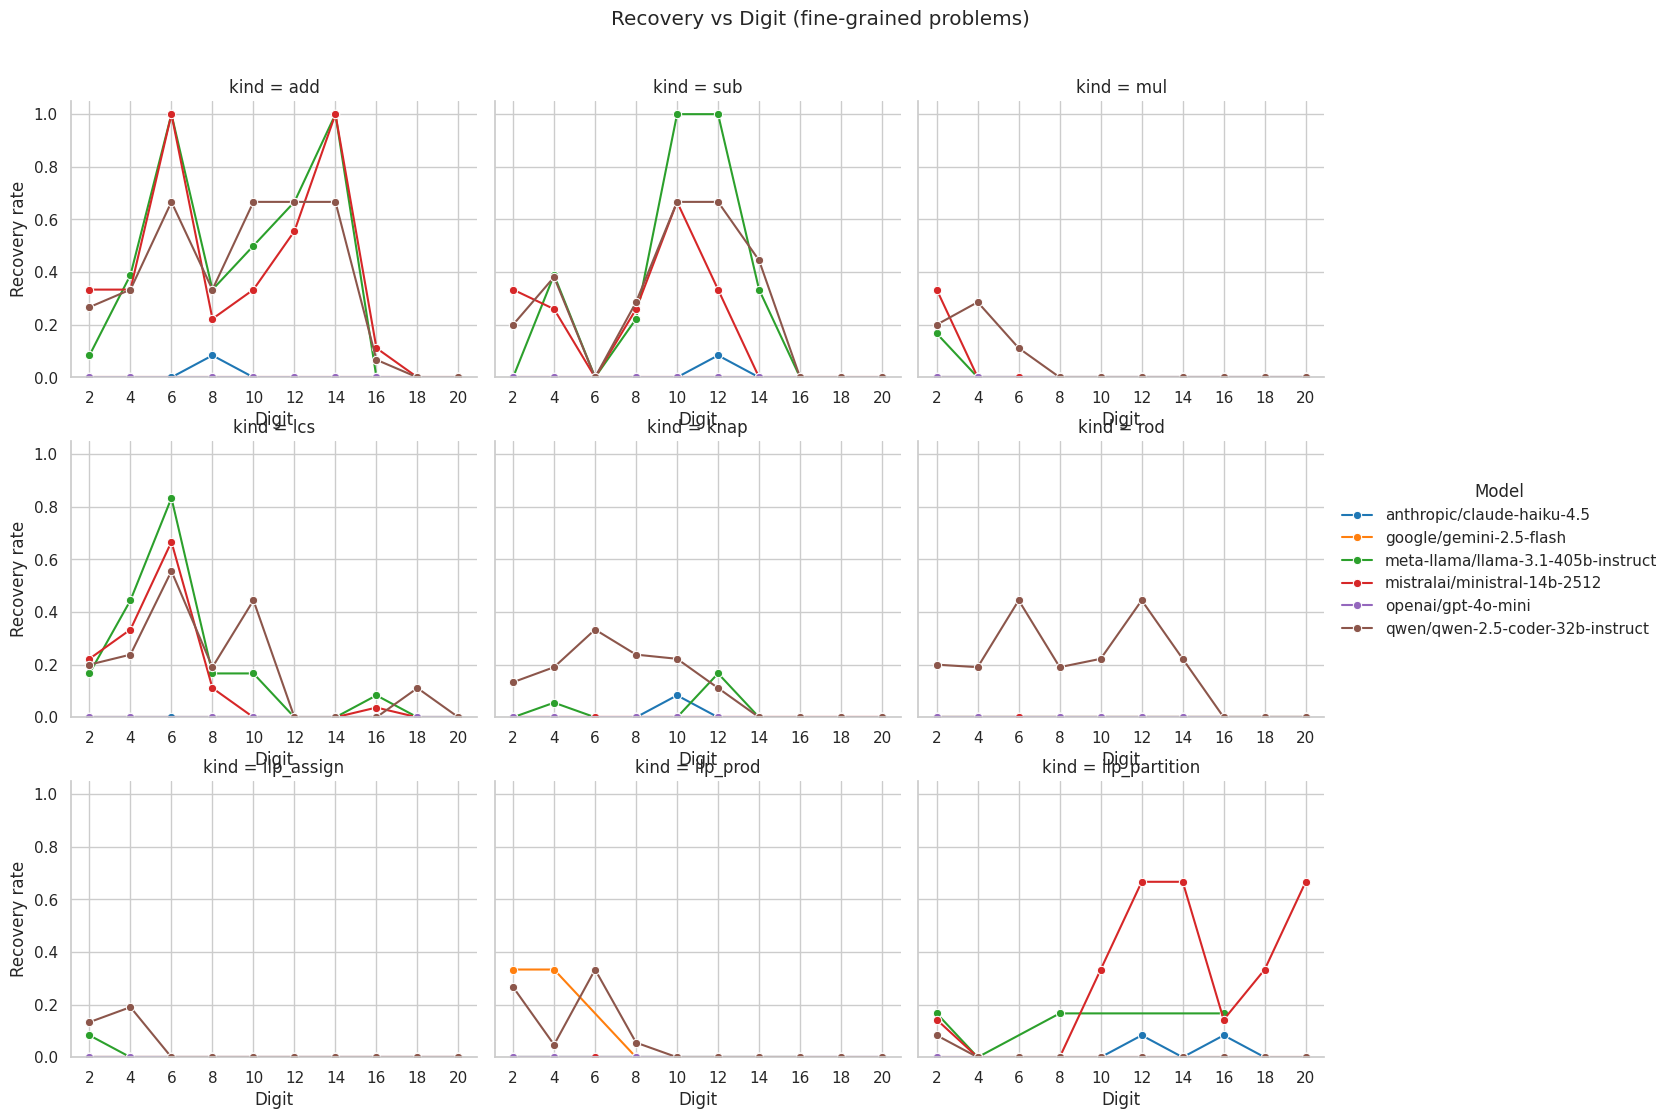

In [197]:
if recovery_stats.empty:
    raise RuntimeError("No recovery statistics available after grouping; check filters or data availability.")

kind_order = [k for k in FINEGRAINED_KIND_ORDER if k in recovery_stats["kind"].unique()]
digit_order = sorted(recovery_stats["digit"].unique())

models = sorted(recovery_stats["model"].unique())
palette = sns.color_palette("tab10", n_colors=len(models))
palette_map = dict(zip(models, palette))

# Fit simple linear trends per (model, kind)
fit_frames: list[pd.DataFrame] = []
for (model, kind), grp in recovery_stats.groupby(["model", "kind"]):
    x = grp["digit"].to_numpy()
    y = grp["recovery_rate"].to_numpy()
    if len(np.unique(x)) < 2:
        continue  # not enough points to fit
    coef = np.polyfit(x, y, deg=1)
    x_pred = np.linspace(x.min(), x.max(), num=50)
    y_pred = np.polyval(coef, x_pred)
    fit_frames.append(
        pd.DataFrame(
            {
                "model": model,
                "kind": kind,
                "digit": x_pred,
                "recovery_rate": y_pred,
            }
        )
    )

fit_df = pd.concat(fit_frames, ignore_index=True) if fit_frames else pd.DataFrame()

plot_kwargs = {
    "x": "digit",
    "y": "recovery_rate",
    "hue": "model",
    "hue_order": models,
    "errorbar": None,
    "marker": "o",
    "palette": palette,
}

g = sns.FacetGrid(
    recovery_stats,
    col="kind",
    col_wrap=3,
    sharey=True,
    sharex=False,
    col_order=kind_order,
    height=3.8,
    aspect=1.2,
)
g.map_dataframe(sns.lineplot, **plot_kwargs)

# Overlay fitted lines (dashed) using the same colors
if not fit_df.empty:
    for ax in g.axes.flatten():
        kind = ax.get_title()
        for model in models:
            sub = fit_df[(fit_df["kind"] == kind) & (fit_df["model"] == model)]
            if sub.empty:
                continue
            ax.plot(sub["digit"], sub["recovery_rate"], linestyle="--", color=palette_map[model], alpha=0.9, label=f"{model} fit")

# Tune axes
for ax in g.axes.flatten():
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Recovery rate")
    ax.set_xlabel("Digit")
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Legend and layout
handles, labels = g.axes[0].get_legend_handles_labels()
g.add_legend(handles=handles, labels=labels, title="Model")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Recovery vs Digit (fine-grained problems)")

plt.show()

In [198]:
# Save the latest FacetGrid figure
try:
    fig = g.fig
except NameError as exc:  # noqa: F821
    raise RuntimeError("Plot grid 'g' is not defined. Run the plotting cell first.") from exc

figures_dir = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/figures")
figures_dir.mkdir(parents=True, exist_ok=True)

out_path = figures_dir / "recovery_vs_digits.png"
fig.savefig(out_path, bbox_inches="tight", dpi=300)
print(f"Saved figure to {out_path}")

out_path

Saved figure to /nlpgpu/data/terry/ToolProj/src/exps_performance/figures/recovery_vs_digits.png


PosixPath('/nlpgpu/data/terry/ToolProj/src/exps_performance/figures/recovery_vs_digits.png')

Overall recovery by digit:


,digit,recovery_rate,total,std
0,2,0.114379,612,0.318531
1,4,0.123769,711,0.329550
2,6,0.174074,270,0.379877
3,8,0.080933,729,0.272919
4,10,0.119883,342,0.325301
5,12,0.116959,342,0.321842
6,14,0.090643,342,0.287522
7,16,0.019048,630,0.136801
8,18,0.005848,342,0.076360
9,20,0.005848,342,0.076360



Correlation: r = -0.818, p = 0.00382


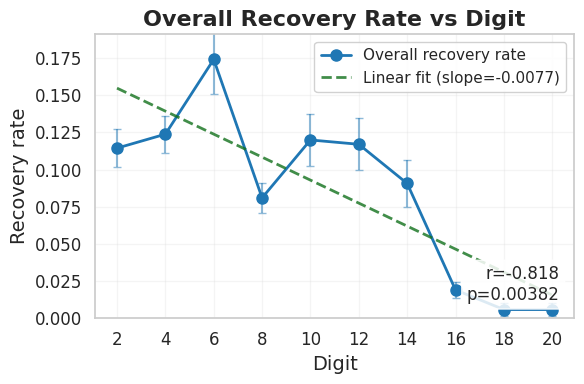

In [199]:
# Overall recovery rate vs digit (aggregated across all tasks and models)
overall_recovery = (
    df.groupby("digit")
    .agg(
        recovery_rate=("recovery", "mean"),
        total=("recovery", "size"),
        std=("recovery", "std"),
    )
    .reset_index()
    .sort_values("digit")
)

print("Overall recovery by digit:")
display(overall_recovery)

# Fit a trend line and compute correlation
x_overall = overall_recovery["digit"].to_numpy()
y_overall = overall_recovery["recovery_rate"].to_numpy()

if len(x_overall) >= 2:
    # Compute correlation and p-value
    from scipy.stats import pearsonr

    r_overall, p_overall = pearsonr(x_overall, y_overall)
    print(f"\nCorrelation: r = {r_overall:.3f}, p = {p_overall:.3g}")

    coef_overall = np.polyfit(x_overall, y_overall, deg=1)
    x_pred_overall = np.linspace(x_overall.min(), x_overall.max(), num=100)
    y_pred_overall = np.polyval(coef_overall, x_pred_overall)

    # Create the plot
    fig_overall = plt.figure(figsize=(6, 4))
    ax_overall = fig_overall.add_subplot(111)

    # Plot data points
    ax_overall.plot(
        overall_recovery["digit"],
        overall_recovery["recovery_rate"],
        marker="o",
        markersize=8,
        linewidth=2,
        color=sns.color_palette("tab10")[0],
        label="Overall recovery rate",
    )

    # Plot fitted line
    ax_overall.plot(
        x_pred_overall,
        y_pred_overall,
        linestyle="--",
        linewidth=2,
        color=sns.color_palette("dark")[2],
        alpha=0.8,
        label=f"Linear fit (slope={coef_overall[0]:.4f})",
    )

    # Add error bars (standard error for proportions)
    # Standard error = sqrt(p(1-p)/n) for proportion p with sample size n
    se_overall = np.sqrt(overall_recovery["recovery_rate"] * (1 - overall_recovery["recovery_rate"]) / overall_recovery["total"])
    ax_overall.errorbar(
        overall_recovery["digit"],
        overall_recovery["recovery_rate"],
        yerr=se_overall,
        fmt="none",
        color=sns.color_palette("tab10")[0],
        alpha=0.5,
        capsize=3,
    )

    # Zoom in on y-axis: set limits based on data range with small margins
    y_min = y_overall.min()
    y_max = y_overall.max()
    y_range = y_max - y_min
    y_margin = y_range * 0.1  # 10% margin on each side
    ax_overall.set_ylim(max(0, y_min - y_margin), min(1.0, y_max + y_margin))

    ax_overall.set_xlabel("Digit", fontsize=14)
    ax_overall.set_ylabel("Recovery rate", fontsize=14)
    ax_overall.set_title("Overall Recovery Rate vs Digit", fontsize=16, fontweight="bold")
    ax_overall.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax_overall.grid(True, alpha=0.2)
    ax_overall.legend(fontsize=11, framealpha=0.9)

    # Add correlation and p-value annotation
    ax_overall.annotate(
        f"r={r_overall:.3f}\np={p_overall:.3g}",
        xy=(0.97, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85),
        fontsize=12,
    )

    ax_overall.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points for overall recovery plot")
    fig_overall = None

In [200]:
# Save the overall recovery vs digit figure
figures_dir = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/figures")
figures_dir.mkdir(parents=True, exist_ok=True)

if "fig_overall" in globals() and fig_overall is not None:
    out_path_overall = figures_dir / "recovery_vs_digits_overall.png"
    fig_overall.savefig(out_path_overall, bbox_inches="tight", dpi=300)
    print(f"Saved figure to {out_path_overall}")
else:
    print("Warning: fig_overall not available for saving")

Saved figure to /nlpgpu/data/terry/ToolProj/src/exps_performance/figures/recovery_vs_digits_overall.png


In [201]:
# Compute accuracy on code exec, code sim, and nl per (model, kind)
# Aggregate across all digits for each (model, kind) combination
accuracy_stats = (
    df.groupby(["model", "kind"])
    .agg(
        code_exec_accuracy=("code_correct", "mean"),
        code_sim_accuracy=("sim_correct", "mean"),
        nl_accuracy=("nl_correct", "mean"),
        recovery_rate=("recovery", "mean"),
        total=("recovery", "size"),
    )
    .reset_index()
)

# Compute averaged accuracy (mean of code_exec and code_sim only, excluding nl)
accuracy_stats["averaged_accuracy"] = accuracy_stats[["code_exec_accuracy", "code_sim_accuracy"]].mean(axis=1)

# Stable categorical ordering
accuracy_stats["kind_ordered"] = pd.Categorical(accuracy_stats["kind"], categories=FINEGRAINED_KIND_ORDER, ordered=True)

accuracy_stats = accuracy_stats.sort_values(
    [
        "kind_ordered",
        "model",
    ]
).reset_index(drop=True)

print("Accuracy summary (top 10 rows):")
display(accuracy_stats.head(10))

print(f"\nTotal rows: {len(accuracy_stats)}")
print(f"Models: {accuracy_stats['model'].nunique()}")
print(f"Kinds: {accuracy_stats['kind'].nunique()}")

Accuracy summary (top 10 rows):


,model,kind,code_exec_accuracy,code_sim_accuracy,nl_accuracy,recovery_rate,total,averaged_accuracy,kind_ordered
0,anthropic/claude-haiku-4.5,add,0.711712,0.720721,0.486486,0.009009,111,0.716216,add
1,google/gemini-2.5-flash,add,0.740741,0.740741,0.703704,0.000000,27,0.740741,add
2,meta-llama/llama-3.1-405b-instruct,add,0.354167,0.666667,0.312500,0.343750,96,0.510417,add
3,mistralai/ministral-14b-2512,add,0.425926,0.672840,0.351852,0.327160,162,0.549383,add
4,openai/gpt-4o-mini,add,0.740741,0.555556,0.555556,0.000000,27,0.648148,add
5,qwen/qwen-2.5-coder-32b-instruct,add,0.261905,0.603175,0.055556,0.341270,126,0.432540,add
6,anthropic/claude-haiku-4.5,sub,0.558559,0.567568,0.387387,0.009009,111,0.563063,sub
7,google/gemini-2.5-flash,sub,0.555556,0.518519,0.518519,0.000000,27,0.537037,sub
8,meta-llama/llama-3.1-405b-instruct,sub,0.260417,0.520833,0.250000,0.260417,96,0.390625,sub
9,mistralai/ministral-14b-2512,sub,0.296296,0.493827,0.296296,0.197531,162,0.395062,sub



Total rows: 54
Models: 6
Kinds: 9


Recovery vs Code Exec: Pearson r = -0.399, p = 0.00283, N = 54


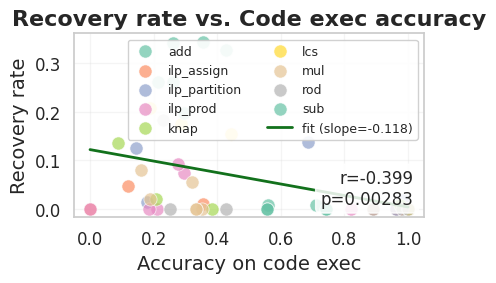

In [202]:
from scipy.stats import pearsonr

# Plot 1: Recovery rate vs Code Exec Accuracy
clean_df_exec = accuracy_stats.dropna(subset=["recovery_rate", "code_exec_accuracy"])

if len(clean_df_exec) >= 2 and clean_df_exec["code_exec_accuracy"].nunique() >= 2:
    r_exec, p_exec = pearsonr(clean_df_exec["recovery_rate"], clean_df_exec["code_exec_accuracy"])
    print(f"Recovery vs Code Exec: Pearson r = {r_exec:.3f}, p = {p_exec:.3g}, N = {len(clean_df_exec)}")

    x_exec = clean_df_exec["code_exec_accuracy"].to_numpy()
    y_exec = clean_df_exec["recovery_rate"].to_numpy()

    # Fit regression line
    slope_exec, intercept_exec = np.polyfit(x_exec, y_exec, 1)
    x_line_exec = np.linspace(x_exec.min(), x_exec.max(), 100)
    y_line_exec = slope_exec * x_line_exec + intercept_exec

    # Get unique kinds for coloring
    kinds = sorted(clean_df_exec["kind"].unique())
    n_kinds = len(kinds)
    palette_kinds = sns.color_palette("Set2", n_colors=n_kinds)
    color_map = {kind: palette_kinds[i] for i, kind in enumerate(kinds)}

    # Color by kind (task)
    fig_exec = plt.figure(figsize=(4.5, 3))
    ax_exec = fig_exec.add_subplot(111)
    for kind in kinds:
        kind_data = clean_df_exec[clean_df_exec["kind"] == kind]
        ax_exec.scatter(
            kind_data["code_exec_accuracy"],
            kind_data["recovery_rate"],
            c=[color_map[kind]],
            label=kind,
            alpha=0.7,
            s=90,
            edgecolors="white",
            linewidth=0.6,
        )

    ax_exec.plot(
        x_line_exec,
        y_line_exec,
        color=sns.color_palette("dark")[2],
        linewidth=2,
        label=f"fit (slope={slope_exec:.3f})",
    )
    ax_exec.set_xlabel("Accuracy on code exec", fontsize=14)
    ax_exec.set_ylabel("Recovery rate", fontsize=14)
    ax_exec.set_title("Recovery rate vs. Code exec accuracy", fontsize=16, fontweight="bold")
    ax_exec.legend(fontsize=9, loc="best", framealpha=0.9, ncol=2)
    ax_exec.grid(True, alpha=0.2)
    ax_exec.annotate(
        f"r={r_exec:.3f}\np={p_exec:.3g}",
        xy=(0.97, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85),
        fontsize=12,
    )
    ax_exec.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough distinct points for correlation/regression.")
    fig_exec = None

Recovery vs Code Sim: Pearson r = 0.465, p = 0.000393, N = 54


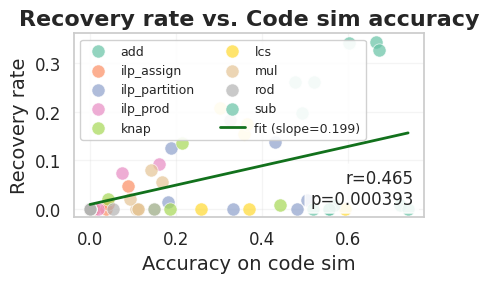

In [203]:
# Plot 2: Recovery rate vs Code Sim Accuracy
clean_df_sim = accuracy_stats.dropna(subset=["recovery_rate", "code_sim_accuracy"])

if len(clean_df_sim) >= 2 and clean_df_sim["code_sim_accuracy"].nunique() >= 2:
    r_sim, p_sim = pearsonr(clean_df_sim["recovery_rate"], clean_df_sim["code_sim_accuracy"])
    print(f"Recovery vs Code Sim: Pearson r = {r_sim:.3f}, p = {p_sim:.3g}, N = {len(clean_df_sim)}")

    x_sim = clean_df_sim["code_sim_accuracy"].to_numpy()
    y_sim = clean_df_sim["recovery_rate"].to_numpy()

    # Fit regression line
    slope_sim, intercept_sim = np.polyfit(x_sim, y_sim, 1)
    x_line_sim = np.linspace(x_sim.min(), x_sim.max(), 100)
    y_line_sim = slope_sim * x_line_sim + intercept_sim

    # Get unique kinds for coloring (reuse same color map)
    kinds = sorted(clean_df_sim["kind"].unique())
    n_kinds = len(kinds)
    palette_kinds = sns.color_palette("Set2", n_colors=n_kinds)
    color_map = {kind: palette_kinds[i] for i, kind in enumerate(kinds)}

    # Color by kind (task)
    fig_sim = plt.figure(figsize=(4.5, 3))
    ax_sim = fig_sim.add_subplot(111)
    for kind in kinds:
        kind_data = clean_df_sim[clean_df_sim["kind"] == kind]
        ax_sim.scatter(
            kind_data["code_sim_accuracy"],
            kind_data["recovery_rate"],
            c=[color_map[kind]],
            label=kind,
            alpha=0.7,
            s=90,
            edgecolors="white",
            linewidth=0.6,
        )

    ax_sim.plot(
        x_line_sim,
        y_line_sim,
        color=sns.color_palette("dark")[2],
        linewidth=2,
        label=f"fit (slope={slope_sim:.3f})",
    )
    ax_sim.set_xlabel("Accuracy on code sim", fontsize=14)
    ax_sim.set_ylabel("Recovery rate", fontsize=14)
    ax_sim.set_title("Recovery rate vs. Code sim accuracy", fontsize=16, fontweight="bold")
    ax_sim.legend(fontsize=9, loc="best", framealpha=0.9, ncol=2)
    ax_sim.grid(True, alpha=0.2)
    ax_sim.annotate(
        f"r={r_sim:.3f}\np={p_sim:.3g}",
        xy=(0.97, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85),
        fontsize=12,
    )
    ax_sim.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough distinct points for correlation/regression.")
    fig_sim = None

In [204]:
# Save the recovery vs accuracy figures
figures_dir = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/figures")
figures_dir.mkdir(parents=True, exist_ok=True)

# Save code exec plot
if "fig_exec" in globals() and fig_exec is not None:
    out_path_exec = figures_dir / "recovery_vs_code_exec_accuracy.png"
    fig_exec.savefig(out_path_exec, bbox_inches="tight", dpi=300)
    print(f"Saved figure to {out_path_exec}")
else:
    print("Warning: fig_exec not available for saving")

# Save code sim plot
if "fig_sim" in globals() and fig_sim is not None:
    out_path_sim = figures_dir / "recovery_vs_code_sim_accuracy.png"
    fig_sim.savefig(out_path_sim, bbox_inches="tight", dpi=300)
    print(f"Saved figure to {out_path_sim}")
else:
    print("Warning: fig_sim not available for saving")

Saved figure to /nlpgpu/data/terry/ToolProj/src/exps_performance/figures/recovery_vs_code_exec_accuracy.png
Saved figure to /nlpgpu/data/terry/ToolProj/src/exps_performance/figures/recovery_vs_code_sim_accuracy.png


In [205]:
def fit_power_law(x, y):
    """Fit power law y = a * x^b using log-linear regression."""
    # Filter out zeros and negatives for log
    mask = (x > 0) & (y > 0)
    if mask.sum() < 2:
        return None, None, None

    x_clean = x[mask]
    y_clean = y[mask]

    # Log-linear fit: log(y) = log(a) + b * log(x)
    log_x = np.log(x_clean)
    log_y = np.log(y_clean)

    # Fit linear in log space
    coef = np.polyfit(log_x, log_y, 1)
    log_a = coef[1]
    b = coef[0]
    a = np.exp(log_a)

    return a, b, mask


def plot_recovery_vs_accuracy(df_plot, x_col, y_col, title_prefix, xlabel, figsize=(4.5, 3)):
    """Create normal, log, and power plots for recovery rate vs accuracy."""
    clean_df = df_plot.dropna(subset=[y_col, x_col])

    if len(clean_df) < 2 or clean_df[x_col].nunique() < 2:
        print(f"Not enough data for {title_prefix}")
        return None, None, None

    x = clean_df[x_col].to_numpy()
    y = clean_df[y_col].to_numpy()

    # Get unique kinds for coloring
    kinds = sorted(clean_df["kind"].unique())
    n_kinds = len(kinds)
    palette_kinds = sns.color_palette("Set2", n_colors=n_kinds)
    color_map = {kind: palette_kinds[i] for i, kind in enumerate(kinds)}

    # Compute correlations
    r, p = pearsonr(x, y)

    # 1. Normal plot (linear)
    slope, intercept = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept

    fig_normal = plt.figure(figsize=figsize)
    ax_normal = fig_normal.add_subplot(111)
    for kind in kinds:
        kind_data = clean_df[clean_df["kind"] == kind]
        ax_normal.scatter(
            kind_data[x_col],
            kind_data[y_col],
            c=[color_map[kind]],
            label=kind,
            alpha=0.7,
            s=90,
            edgecolors="white",
            linewidth=0.6,
        )
    ax_normal.plot(x_line, y_line, color=sns.color_palette("dark")[2], linewidth=2, label=f"fit (slope={slope:.3f})")
    ax_normal.set_xlabel(xlabel, fontsize=14)
    ax_normal.set_ylabel("Recovery rate", fontsize=14)
    ax_normal.set_title(f"{title_prefix} (Linear)", fontsize=16, fontweight="bold")
    ax_normal.legend(fontsize=9, loc="best", framealpha=0.9, ncol=2)
    ax_normal.grid(True, alpha=0.2)
    ax_normal.annotate(
        f"r={r:.3f}\np={p:.3g}",
        xy=(0.97, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85),
        fontsize=12,
    )
    ax_normal.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

    # 2. Log plot (log-log scale)
    # Filter out zeros and negatives
    mask_log = (x > 0) & (y > 0)
    if mask_log.sum() < 2:
        fig_log = None
    else:
        x_log = x[mask_log]
        y_log = y[mask_log]
        clean_df_log = clean_df[mask_log].reset_index(drop=True)

        # Fit in log space
        log_x = np.log(x_log)
        log_y = np.log(y_log)
        slope_log, intercept_log = np.polyfit(log_x, log_y, 1)
        x_line_log = np.linspace(log_x.min(), log_x.max(), 100)
        y_line_log = slope_log * x_line_log + intercept_log

        r_log, p_log = pearsonr(log_x, log_y)

        fig_log = plt.figure(figsize=figsize)
        ax_log = fig_log.add_subplot(111)
        for kind in kinds:
            kind_data = clean_df_log[clean_df_log["kind"] == kind]
            if len(kind_data) > 0:
                ax_log.scatter(
                    kind_data[x_col],
                    kind_data[y_col],
                    c=[color_map[kind]],
                    label=kind,
                    alpha=0.7,
                    s=90,
                    edgecolors="white",
                    linewidth=0.6,
                )
        ax_log.plot(np.exp(x_line_log), np.exp(y_line_log), color=sns.color_palette("dark")[2], linewidth=2, label=f"fit (slope={slope_log:.3f})")
        ax_log.set_xscale("log")
        ax_log.set_yscale("log")
        ax_log.set_xlabel(xlabel, fontsize=14)
        ax_log.set_ylabel("Recovery rate", fontsize=14)
        ax_log.set_title(f"{title_prefix} (Log-Log)", fontsize=16, fontweight="bold")
        ax_log.legend(fontsize=9, loc="best", framealpha=0.9, ncol=2)
        ax_log.grid(True, alpha=0.2)
        ax_log.annotate(
            f"r={r_log:.3f}\np={p_log:.3g}",
            xy=(0.97, 0.05),
            xycoords="axes fraction",
            ha="right",
            va="bottom",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85),
            fontsize=12,
        )
        ax_log.tick_params(labelsize=12)
        plt.tight_layout()
        plt.show()

    # 3. Power plot (power law fit)
    a, b, mask_power = fit_power_law(x, y)
    if a is not None and mask_power.sum() >= 2:
        x_power = x[mask_power]
        y_power = y[mask_power]
        clean_df_power = clean_df[mask_power].reset_index(drop=True)

        x_line_power = np.linspace(x_power.min(), x_power.max(), 100)
        y_line_power = a * (x_line_power**b)

        # Compute correlation in log space
        r_power, p_power = pearsonr(np.log(x_power), np.log(y_power))

        fig_power = plt.figure(figsize=figsize)
        ax_power = fig_power.add_subplot(111)
        for kind in kinds:
            kind_data = clean_df_power[clean_df_power["kind"] == kind]
            if len(kind_data) > 0:
                ax_power.scatter(
                    kind_data[x_col],
                    kind_data[y_col],
                    c=[color_map[kind]],
                    label=kind,
                    alpha=0.7,
                    s=90,
                    edgecolors="white",
                    linewidth=0.6,
                )
        ax_power.plot(x_line_power, y_line_power, color=sns.color_palette("dark")[2], linewidth=2, label=f"fit (y={a:.3f}*x^{b:.3f})")
        ax_power.set_xlabel(xlabel, fontsize=14)
        ax_power.set_ylabel("Recovery rate", fontsize=14)
        ax_power.set_title(f"{title_prefix} (Power Law)", fontsize=16, fontweight="bold")
        ax_power.legend(fontsize=9, loc="best", framealpha=0.9, ncol=2)
        ax_power.grid(True, alpha=0.2)
        ax_power.annotate(
            f"r={r_power:.3f}\np={p_power:.3g}",
            xy=(0.97, 0.05),
            xycoords="axes fraction",
            ha="right",
            va="bottom",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85),
            fontsize=12,
        )
        ax_power.tick_params(labelsize=12)
        plt.tight_layout()
        plt.show()
    else:
        fig_power = None

    return fig_normal, fig_log, fig_power

=== Recovery Rate vs Code Exec Accuracy ===


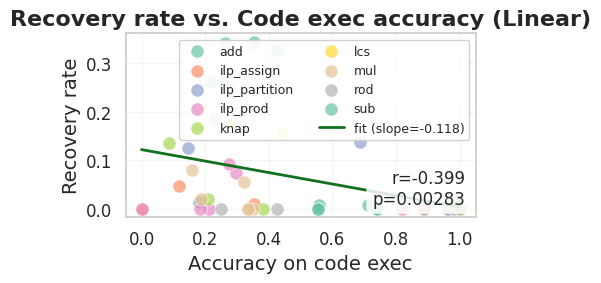

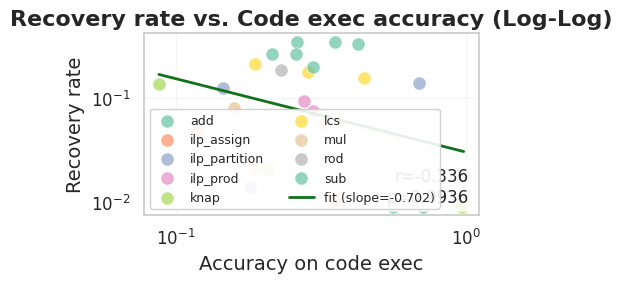

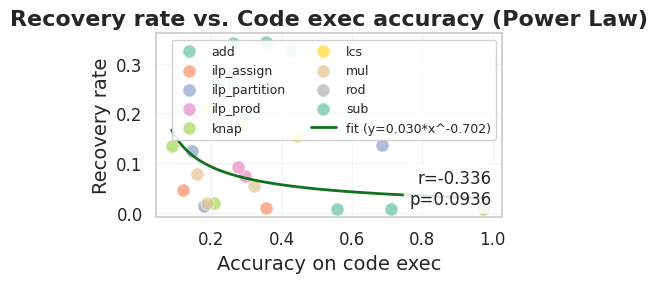

In [206]:
# Generate plots for recovery rate vs code_exec_accuracy
print("=== Recovery Rate vs Code Exec Accuracy ===")
fig_exec_normal, fig_exec_log, fig_exec_power = plot_recovery_vs_accuracy(
    accuracy_stats,
    "code_exec_accuracy",
    "recovery_rate",
    "Recovery rate vs. Code exec accuracy",
    "Accuracy on code exec",
)

=== Recovery Rate vs Code Sim Accuracy ===


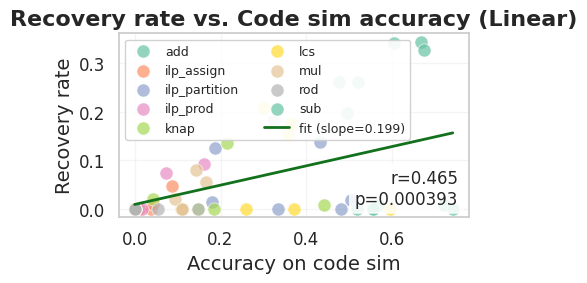

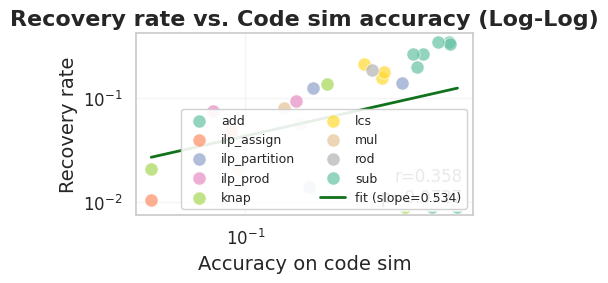

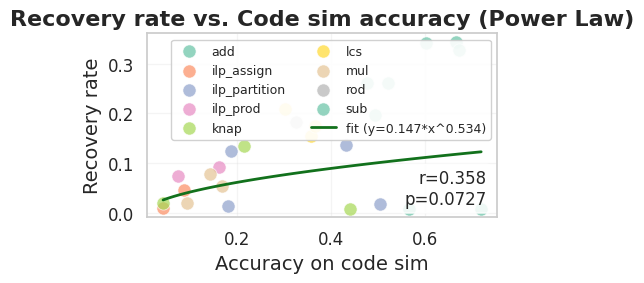

In [207]:
# Generate plots for recovery rate vs code_sim_accuracy
print("=== Recovery Rate vs Code Sim Accuracy ===")
fig_sim_normal, fig_sim_log, fig_sim_power = plot_recovery_vs_accuracy(
    accuracy_stats,
    "code_sim_accuracy",
    "recovery_rate",
    "Recovery rate vs. Code sim accuracy",
    "Accuracy on code sim",
)

=== Recovery Rate vs Averaged Accuracy (code_exec + code_sim) ===


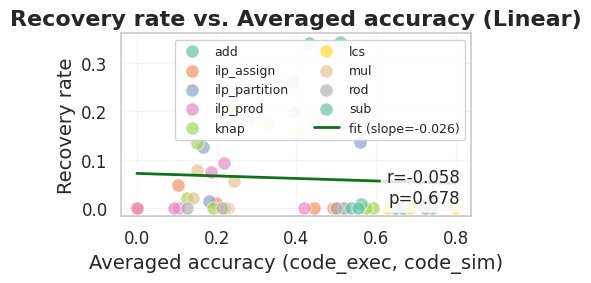

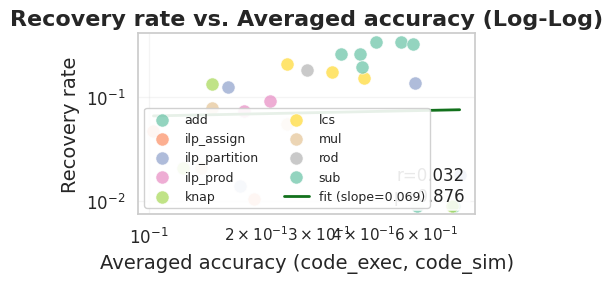

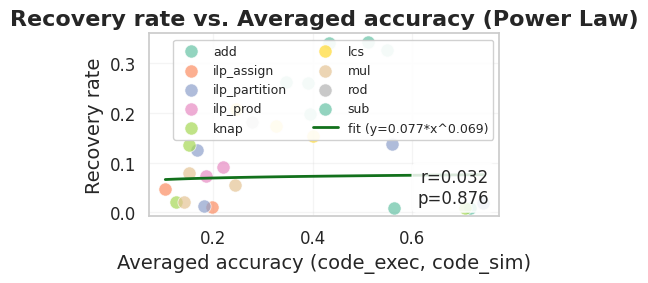

In [208]:
# Generate plots for recovery rate vs averaged_accuracy
print("=== Recovery Rate vs Averaged Accuracy (code_exec + code_sim) ===")
fig_avg_normal, fig_avg_log, fig_avg_power = plot_recovery_vs_accuracy(
    accuracy_stats,
    "averaged_accuracy",
    "recovery_rate",
    "Recovery rate vs. Averaged accuracy",
    "Averaged accuracy (code_exec, code_sim)",
)

In [209]:
# Save all the new plots
figures_dir = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/figures")
figures_dir.mkdir(parents=True, exist_ok=True)

# Save code exec plots
if "fig_exec_normal" in globals() and fig_exec_normal is not None:
    fig_exec_normal.savefig(figures_dir / "recovery_vs_code_exec_linear.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_exec_linear.png")
if "fig_exec_log" in globals() and fig_exec_log is not None:
    fig_exec_log.savefig(figures_dir / "recovery_vs_code_exec_log.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_exec_log.png")
if "fig_exec_power" in globals() and fig_exec_power is not None:
    fig_exec_power.savefig(figures_dir / "recovery_vs_code_exec_power.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_exec_power.png")

# Save code sim plots
if "fig_sim_normal" in globals() and fig_sim_normal is not None:
    fig_sim_normal.savefig(figures_dir / "recovery_vs_code_sim_linear.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_sim_linear.png")
if "fig_sim_log" in globals() and fig_sim_log is not None:
    fig_sim_log.savefig(figures_dir / "recovery_vs_code_sim_log.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_sim_log.png")
if "fig_sim_power" in globals() and fig_sim_power is not None:
    fig_sim_power.savefig(figures_dir / "recovery_vs_code_sim_power.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_sim_power.png")

# Save averaged accuracy plots
if "fig_avg_normal" in globals() and fig_avg_normal is not None:
    fig_avg_normal.savefig(figures_dir / "recovery_vs_avg_accuracy_linear.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_avg_accuracy_linear.png")
if "fig_avg_log" in globals() and fig_avg_log is not None:
    fig_avg_log.savefig(figures_dir / "recovery_vs_avg_accuracy_log.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_avg_accuracy_log.png")
if "fig_avg_power" in globals() and fig_avg_power is not None:
    fig_avg_power.savefig(figures_dir / "recovery_vs_avg_accuracy_power.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_avg_accuracy_power.png")

Saved: recovery_vs_code_exec_linear.png
Saved: recovery_vs_code_exec_log.png
Saved: recovery_vs_code_exec_power.png
Saved: recovery_vs_code_sim_linear.png
Saved: recovery_vs_code_sim_log.png
Saved: recovery_vs_code_sim_power.png
Saved: recovery_vs_avg_accuracy_linear.png
Saved: recovery_vs_avg_accuracy_log.png
Saved: recovery_vs_avg_accuracy_power.png


In [210]:
def categorize_model_type(model_name: str) -> str:
    """Categorize model as 'open' or 'closed' based on name.
    Open models: meta-llama, mistralai, qwen
    Closed models: anthropic, openai, google
    """
    model_lower = model_name.lower()
    # Open source models: meta-llama, mistralai, qwen
    if any(x in model_lower for x in ["meta-llama", "llama", "mistralai", "mistral", "qwen"]):
        return "open"
    # Closed source models: anthropic, openai, google
    elif any(x in model_lower for x in ["anthropic", "openai", "google"]):
        return "closed"
    else:
        # Default to closed if unknown
        return "closed"


def plot_recovery_vs_accuracy_with_model_types(df_plot, x_col, y_col, title_prefix, xlabel, figsize=(4.5, 3)):
    """Create normal, log-log, log-linear, and power plots for recovery rate vs accuracy,
    with separate lines for open/closed models and an average line.
    Computes correlations and p-values for each line separately."""
    clean_df = df_plot.dropna(subset=[y_col, x_col])

    if len(clean_df) < 2 or clean_df[x_col].nunique() < 2:
        print(f"Not enough data for {title_prefix}")
        return None, None, None, None

    # Categorize models
    clean_df = clean_df.copy()
    clean_df["model_type"] = clean_df["model"].apply(categorize_model_type)

    # Get unique kinds for coloring
    kinds = sorted(clean_df["kind"].unique())
    n_kinds = len(kinds)
    palette_kinds = sns.color_palette("Set2", n_colors=n_kinds)
    color_map = {kind: palette_kinds[i] for i, kind in enumerate(kinds)}

    x_all = clean_df[x_col].to_numpy()
    y_all = clean_df[y_col].to_numpy()

    # Separate by model type
    df_open = clean_df[clean_df["model_type"] == "open"]
    df_closed = clean_df[clean_df["model_type"] == "closed"]

    print(f"Open models: {df_open['model'].nunique()}, Closed models: {df_closed['model'].nunique()}")

    # Compute overall correlation
    r_all, p_all = pearsonr(x_all, y_all)

    # 1. Normal plot (linear)
    slope_all, intercept_all = np.polyfit(x_all, y_all, 1)
    x_line_all = np.linspace(x_all.min(), x_all.max(), 100)
    y_line_all = slope_all * x_line_all + intercept_all

    # Fit for open models
    r_open, p_open, slope_open, x_line_open, y_line_open = None, None, None, None, None
    if len(df_open) >= 2:
        x_open = df_open[x_col].to_numpy()
        y_open = df_open[y_col].to_numpy()
        r_open, p_open = pearsonr(x_open, y_open)
        slope_open, intercept_open = np.polyfit(x_open, y_open, 1)
        x_line_open = np.linspace(x_open.min(), x_open.max(), 100)
        y_line_open = slope_open * x_line_open + intercept_open

    # Fit for closed models
    r_closed, p_closed, slope_closed, x_line_closed, y_line_closed = None, None, None, None, None
    if len(df_closed) >= 2:
        x_closed = df_closed[x_col].to_numpy()
        y_closed = df_closed[y_col].to_numpy()
        r_closed, p_closed = pearsonr(x_closed, y_closed)
        slope_closed, intercept_closed = np.polyfit(x_closed, y_closed, 1)
        x_line_closed = np.linspace(x_closed.min(), x_closed.max(), 100)
        y_line_closed = slope_closed * x_line_closed + intercept_closed

    fig_normal = plt.figure(figsize=figsize)
    ax_normal = fig_normal.add_subplot(111)

    # Plot scatter points colored by kind
    for kind in kinds:
        kind_data = clean_df[clean_df["kind"] == kind]
        ax_normal.scatter(
            kind_data[x_col],
            kind_data[y_col],
            c=[color_map[kind]],
            label=kind,
            alpha=0.7,
            s=90,
            edgecolors="white",
            linewidth=0.6,
        )

    # Plot fit lines
    if x_line_open is not None:
        ax_normal.plot(
            x_line_open, y_line_open, color="blue", linewidth=2.5, linestyle="--", label=f"Open models (slope={slope_open:.3f})", alpha=0.8
        )
    if x_line_closed is not None:
        ax_normal.plot(
            x_line_closed, y_line_closed, color="red", linewidth=2.5, linestyle="--", label=f"Closed models (slope={slope_closed:.3f})", alpha=0.8
        )
    ax_normal.plot(x_line_all, y_line_all, color="black", linewidth=2.5, linestyle="-", label=f"Average (slope={slope_all:.3f})", alpha=0.9)

    ax_normal.set_xlabel(xlabel, fontsize=14)
    ax_normal.set_ylabel("Recovery rate", fontsize=14)
    ax_normal.set_title(f"{title_prefix} (Linear)", fontsize=16, fontweight="bold")
    ax_normal.grid(True, alpha=0.2)

    # Add correlation annotations above the legend on the right
    y_pos = 0.98
    if r_open is not None:
        ax_normal.annotate(
            f"Open: r={r_open:.3f}, p={p_open:.3g}",
            xy=(1.02, y_pos),
            xycoords="axes fraction",
            ha="left",
            va="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.9, edgecolor="blue"),
            fontsize=10,
        )
        y_pos -= 0.08
    if r_closed is not None:
        ax_normal.annotate(
            f"Closed: r={r_closed:.3f}, p={p_closed:.3g}",
            xy=(1.02, y_pos),
            xycoords="axes fraction",
            ha="left",
            va="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.9, edgecolor="red"),
            fontsize=10,
        )
        y_pos -= 0.08
    ax_normal.annotate(
        f"Average: r={r_all:.3f}, p={p_all:.3g}",
        xy=(1.02, y_pos),
        xycoords="axes fraction",
        ha="left",
        va="top",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.9, edgecolor="black"),
        fontsize=10,
    )

    # Place legend below the p-value annotations
    ax_normal.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, y_pos - 0.05), framealpha=0.9, ncol=1)

    ax_normal.tick_params(labelsize=12)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()

    # 2. Log plot (log-log scale)
    mask_log = (x_all > 0) & (y_all > 0)
    if mask_log.sum() < 2:
        fig_log = None
    else:
        clean_df_log = clean_df[mask_log].reset_index(drop=True)
        df_open_log = clean_df_log[clean_df_log["model_type"] == "open"]
        df_closed_log = clean_df_log[clean_df_log["model_type"] == "closed"]

        x_log_all = clean_df_log[x_col].to_numpy()
        y_log_all = clean_df_log[y_col].to_numpy()
        log_x_all = np.log(x_log_all)
        log_y_all = np.log(y_log_all)

        slope_log_all, intercept_log_all = np.polyfit(log_x_all, log_y_all, 1)
        x_line_log_all = np.linspace(log_x_all.min(), log_x_all.max(), 100)
        y_line_log_all = slope_log_all * x_line_log_all + intercept_log_all

        # Fit for open models
        r_log_open, p_log_open, slope_log_open, x_line_log_open, y_line_log_open = None, None, None, None, None
        if len(df_open_log) >= 2:
            x_open_log = df_open_log[x_col].to_numpy()
            y_open_log = df_open_log[y_col].to_numpy()
            log_x_open = np.log(x_open_log)
            log_y_open = np.log(y_open_log)
            r_log_open, p_log_open = pearsonr(log_x_open, log_y_open)
            slope_log_open, intercept_log_open = np.polyfit(log_x_open, log_y_open, 1)
            x_line_log_open = np.linspace(log_x_open.min(), log_x_open.max(), 100)
            y_line_log_open = slope_log_open * x_line_log_open + intercept_log_open

        # Fit for closed models
        r_log_closed, p_log_closed, slope_log_closed, x_line_log_closed, y_line_log_closed = None, None, None, None, None
        if len(df_closed_log) >= 2:
            x_closed_log = df_closed_log[x_col].to_numpy()
            y_closed_log = df_closed_log[y_col].to_numpy()
            log_x_closed = np.log(x_closed_log)
            log_y_closed = np.log(y_closed_log)
            r_log_closed, p_log_closed = pearsonr(log_x_closed, log_y_closed)
            slope_log_closed, intercept_log_closed = np.polyfit(log_x_closed, log_y_closed, 1)
            x_line_log_closed = np.linspace(log_x_closed.min(), log_x_closed.max(), 100)
            y_line_log_closed = slope_log_closed * x_line_log_closed + intercept_log_closed

        r_log_all, p_log_all = pearsonr(log_x_all, log_y_all)

        fig_log = plt.figure(figsize=figsize)
        ax_log = fig_log.add_subplot(111)

        # Plot scatter points
        for kind in kinds:
            kind_data = clean_df_log[clean_df_log["kind"] == kind]
            if len(kind_data) > 0:
                ax_log.scatter(
                    kind_data[x_col],
                    kind_data[y_col],
                    c=[color_map[kind]],
                    label=kind,
                    alpha=0.7,
                    s=90,
                    edgecolors="white",
                    linewidth=0.6,
                )

        # Plot fit lines
        if x_line_log_open is not None:
            ax_log.plot(
                np.exp(x_line_log_open),
                np.exp(y_line_log_open),
                color="blue",
                linewidth=2.5,
                linestyle="--",
                label=f"Open models (slope={slope_log_open:.3f})",
                alpha=0.8,
            )
        if x_line_log_closed is not None:
            ax_log.plot(
                np.exp(x_line_log_closed),
                np.exp(y_line_log_closed),
                color="red",
                linewidth=2.5,
                linestyle="--",
                label=f"Closed models (slope={slope_log_closed:.3f})",
                alpha=0.8,
            )
        ax_log.plot(
            np.exp(x_line_log_all),
            np.exp(y_line_log_all),
            color="black",
            linewidth=2.5,
            linestyle="-",
            label=f"Average (slope={slope_log_all:.3f})",
            alpha=0.9,
        )

        ax_log.set_xscale("log")
        ax_log.set_yscale("log")
        ax_log.set_xlabel(xlabel, fontsize=14)
        ax_log.set_ylabel("Recovery rate", fontsize=14)
        ax_log.set_title(f"{title_prefix} (Log-Log)", fontsize=16, fontweight="bold")
        ax_log.grid(True, alpha=0.2)

        # Add correlation annotations above the legend on the right
        y_pos = 0.98
        if r_log_open is not None:
            ax_log.annotate(
                f"Open: r={r_log_open:.3f}, p={p_log_open:.3g}",
                xy=(1.02, y_pos),
                xycoords="axes fraction",
                ha="left",
                va="top",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.9, edgecolor="blue"),
                fontsize=10,
            )
            y_pos -= 0.08
        if r_log_closed is not None:
            ax_log.annotate(
                f"Closed: r={r_log_closed:.3f}, p={p_log_closed:.3g}",
                xy=(1.02, y_pos),
                xycoords="axes fraction",
                ha="left",
                va="top",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.9, edgecolor="red"),
                fontsize=10,
            )
            y_pos -= 0.08
        ax_log.annotate(
            f"Average: r={r_log_all:.3f}, p={p_log_all:.3g}",
            xy=(1.02, y_pos),
            xycoords="axes fraction",
            ha="left",
            va="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.9, edgecolor="black"),
            fontsize=10,
        )

        # Place legend below the p-value annotations
        ax_log.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, y_pos - 0.05), framealpha=0.9, ncol=1)

        ax_log.tick_params(labelsize=12)
        plt.tight_layout(rect=[0, 0, 0.75, 1])
        plt.show()

    # 3. Log-linear plot (log x-axis, linear y-axis)
    mask_loglin = x_all > 0
    if mask_loglin.sum() < 2:
        fig_loglin = None
    else:
        clean_df_loglin = clean_df[mask_loglin].reset_index(drop=True)
        df_open_loglin = clean_df_loglin[clean_df_loglin["model_type"] == "open"]
        df_closed_loglin = clean_df_loglin[clean_df_loglin["model_type"] == "closed"]

        x_loglin_all = clean_df_loglin[x_col].to_numpy()
        y_loglin_all = clean_df_loglin[y_col].to_numpy()
        log_x_loglin_all = np.log(x_loglin_all)

        # Fit: y = slope * log(x) + intercept
        slope_loglin_all, intercept_loglin_all = np.polyfit(log_x_loglin_all, y_loglin_all, 1)
        x_line_loglin_all = np.linspace(log_x_loglin_all.min(), log_x_loglin_all.max(), 100)
        y_line_loglin_all = slope_loglin_all * x_line_loglin_all + intercept_loglin_all

        # Fit for open models
        r_loglin_open, p_loglin_open, slope_loglin_open, x_line_loglin_open, y_line_loglin_open = None, None, None, None, None
        if len(df_open_loglin) >= 2:
            x_open_loglin = df_open_loglin[x_col].to_numpy()
            y_open_loglin = df_open_loglin[y_col].to_numpy()
            log_x_open_loglin = np.log(x_open_loglin)
            r_loglin_open, p_loglin_open = pearsonr(log_x_open_loglin, y_open_loglin)
            slope_loglin_open, intercept_loglin_open = np.polyfit(log_x_open_loglin, y_open_loglin, 1)
            x_line_loglin_open = np.linspace(log_x_open_loglin.min(), log_x_open_loglin.max(), 100)
            y_line_loglin_open = slope_loglin_open * x_line_loglin_open + intercept_loglin_open

        # Fit for closed models
        r_loglin_closed, p_loglin_closed, slope_loglin_closed, x_line_loglin_closed, y_line_loglin_closed = None, None, None, None, None
        if len(df_closed_loglin) >= 2:
            x_closed_loglin = df_closed_loglin[x_col].to_numpy()
            y_closed_loglin = df_closed_loglin[y_col].to_numpy()
            log_x_closed_loglin = np.log(x_closed_loglin)
            r_loglin_closed, p_loglin_closed = pearsonr(log_x_closed_loglin, y_closed_loglin)
            slope_loglin_closed, intercept_loglin_closed = np.polyfit(log_x_closed_loglin, y_closed_loglin, 1)
            x_line_loglin_closed = np.linspace(log_x_closed_loglin.min(), log_x_closed_loglin.max(), 100)
            y_line_loglin_closed = slope_loglin_closed * x_line_loglin_closed + intercept_loglin_closed

        r_loglin_all, p_loglin_all = pearsonr(log_x_loglin_all, y_loglin_all)

        fig_loglin = plt.figure(figsize=figsize)
        ax_loglin = fig_loglin.add_subplot(111)

        # Plot scatter points
        for kind in kinds:
            kind_data = clean_df_loglin[clean_df_loglin["kind"] == kind]
            if len(kind_data) > 0:
                ax_loglin.scatter(
                    kind_data[x_col],
                    kind_data[y_col],
                    c=[color_map[kind]],
                    label=kind,
                    alpha=0.7,
                    s=90,
                    edgecolors="white",
                    linewidth=0.6,
                )

        # Plot fit lines
        if x_line_loglin_open is not None:
            ax_loglin.plot(
                np.exp(x_line_loglin_open),
                y_line_loglin_open,
                color="blue",
                linewidth=2.5,
                linestyle="--",
                label=f"Open models (slope={slope_loglin_open:.3f})",
                alpha=0.8,
            )
        if x_line_loglin_closed is not None:
            ax_loglin.plot(
                np.exp(x_line_loglin_closed),
                y_line_loglin_closed,
                color="red",
                linewidth=2.5,
                linestyle="--",
                label=f"Closed models (slope={slope_loglin_closed:.3f})",
                alpha=0.8,
            )
        ax_loglin.plot(
            np.exp(x_line_loglin_all),
            y_line_loglin_all,
            color="black",
            linewidth=2.5,
            linestyle="-",
            label=f"Average (slope={slope_loglin_all:.3f})",
            alpha=0.9,
        )

        ax_loglin.set_xscale("log")
        ax_loglin.set_xlabel(xlabel, fontsize=14)
        ax_loglin.set_ylabel("Recovery rate", fontsize=14)
        ax_loglin.set_title(f"{title_prefix} (Log-Linear)", fontsize=16, fontweight="bold")
        ax_loglin.grid(True, alpha=0.2)

        # Add correlation annotations above the legend on the right
        y_pos = 0.98
        if r_loglin_open is not None:
            ax_loglin.annotate(
                f"Open: r={r_loglin_open:.3f}, p={p_loglin_open:.3g}",
                xy=(1.02, y_pos),
                xycoords="axes fraction",
                ha="left",
                va="top",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.9, edgecolor="blue"),
                fontsize=10,
            )
            y_pos -= 0.08
        if r_loglin_closed is not None:
            ax_loglin.annotate(
                f"Closed: r={r_loglin_closed:.3f}, p={p_loglin_closed:.3g}",
                xy=(1.02, y_pos),
                xycoords="axes fraction",
                ha="left",
                va="top",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.9, edgecolor="red"),
                fontsize=10,
            )
            y_pos -= 0.08
        ax_loglin.annotate(
            f"Average: r={r_loglin_all:.3f}, p={p_loglin_all:.3g}",
            xy=(1.02, y_pos),
            xycoords="axes fraction",
            ha="left",
            va="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.9, edgecolor="black"),
            fontsize=10,
        )

        # Place legend below the p-value annotations
        ax_loglin.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, y_pos - 0.05), framealpha=0.9, ncol=1)

        ax_loglin.tick_params(labelsize=12)
        plt.tight_layout(rect=[0, 0, 0.75, 1])
        plt.show()

    # 4. Power plot (power law fit)
    a_all, b_all, mask_power_all = fit_power_law(x_all, y_all)
    if a_all is not None and mask_power_all.sum() >= 2:
        clean_df_power = clean_df[mask_power_all].reset_index(drop=True)
        df_open_power = clean_df_power[clean_df_power["model_type"] == "open"]
        df_closed_power = clean_df_power[clean_df_power["model_type"] == "closed"]

        x_power_all = x_all[mask_power_all]
        y_power_all = y_all[mask_power_all]
        x_line_power_all = np.linspace(x_power_all.min(), x_power_all.max(), 100)
        y_line_power_all = a_all * (x_line_power_all**b_all)

        # Fit for open models
        r_power_open, p_power_open, a_open, b_open, x_line_power_open, y_line_power_open = None, None, None, None, None, None
        if len(df_open_power) >= 2:
            x_open_power = df_open_power[x_col].to_numpy()
            y_open_power = df_open_power[y_col].to_numpy()
            a_open, b_open, _ = fit_power_law(x_open_power, y_open_power)
            if a_open is not None:
                r_power_open, p_power_open = pearsonr(np.log(x_open_power), np.log(y_open_power))
                x_line_power_open = np.linspace(x_open_power.min(), x_open_power.max(), 100)
                y_line_power_open = a_open * (x_line_power_open**b_open)

        # Fit for closed models
        r_power_closed, p_power_closed, a_closed, b_closed, x_line_power_closed, y_line_power_closed = None, None, None, None, None, None
        if len(df_closed_power) >= 2:
            x_closed_power = df_closed_power[x_col].to_numpy()
            y_closed_power = df_closed_power[y_col].to_numpy()
            a_closed, b_closed, _ = fit_power_law(x_closed_power, y_closed_power)
            if a_closed is not None:
                r_power_closed, p_power_closed = pearsonr(np.log(x_closed_power), np.log(y_closed_power))
                x_line_power_closed = np.linspace(x_closed_power.min(), x_closed_power.max(), 100)
                y_line_power_closed = a_closed * (x_line_power_closed**b_closed)

        r_power_all, p_power_all = pearsonr(np.log(x_power_all), np.log(y_power_all))

        fig_power = plt.figure(figsize=figsize)
        ax_power = fig_power.add_subplot(111)

        # Plot scatter points
        for kind in kinds:
            kind_data = clean_df_power[clean_df_power["kind"] == kind]
            if len(kind_data) > 0:
                ax_power.scatter(
                    kind_data[x_col],
                    kind_data[y_col],
                    c=[color_map[kind]],
                    label=kind,
                    alpha=0.7,
                    s=90,
                    edgecolors="white",
                    linewidth=0.6,
                )

        # Plot fit lines
        if x_line_power_open is not None:
            ax_power.plot(
                x_line_power_open,
                y_line_power_open,
                color="blue",
                linewidth=2.5,
                linestyle="--",
                label=f"Open models (y={a_open:.3f}*x^{b_open:.3f})",
                alpha=0.8,
            )
        if x_line_power_closed is not None:
            ax_power.plot(
                x_line_power_closed,
                y_line_power_closed,
                color="red",
                linewidth=2.5,
                linestyle="--",
                label=f"Closed models (y={a_closed:.3f}*x^{b_closed:.3f})",
                alpha=0.8,
            )
        ax_power.plot(
            x_line_power_all, y_line_power_all, color="black", linewidth=2.5, linestyle="-", label=f"Average (y={a_all:.3f}*x^{b_all:.3f})", alpha=0.9
        )

        ax_power.set_xlabel(xlabel, fontsize=14)
        ax_power.set_ylabel("Recovery rate", fontsize=14)
        ax_power.set_title(f"{title_prefix} (Power Law)", fontsize=16, fontweight="bold")
        ax_power.grid(True, alpha=0.2)

        # Add correlation annotations above the legend on the right
        y_pos = 0.98
        if r_power_open is not None:
            ax_power.annotate(
                f"Open: r={r_power_open:.3f}, p={p_power_open:.3g}",
                xy=(1.02, y_pos),
                xycoords="axes fraction",
                ha="left",
                va="top",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.9, edgecolor="blue"),
                fontsize=10,
            )
            y_pos -= 0.08
        if r_power_closed is not None:
            ax_power.annotate(
                f"Closed: r={r_power_closed:.3f}, p={p_power_closed:.3g}",
                xy=(1.02, y_pos),
                xycoords="axes fraction",
                ha="left",
                va="top",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.9, edgecolor="red"),
                fontsize=10,
            )
            y_pos -= 0.08
        ax_power.annotate(
            f"Average: r={r_power_all:.3f}, p={p_power_all:.3g}",
            xy=(1.02, y_pos),
            xycoords="axes fraction",
            ha="left",
            va="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.9, edgecolor="black"),
            fontsize=10,
        )

        # Place legend below the p-value annotations
        ax_power.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, y_pos - 0.05), framealpha=0.9, ncol=1)

        ax_power.tick_params(labelsize=12)
        plt.tight_layout(rect=[0, 0, 0.75, 1])
        plt.show()
    else:
        fig_power = None

    return fig_normal, fig_log, fig_loglin, fig_power

=== Recovery Rate vs NL Accuracy (with model type separation) ===
Open models: 3, Closed models: 3


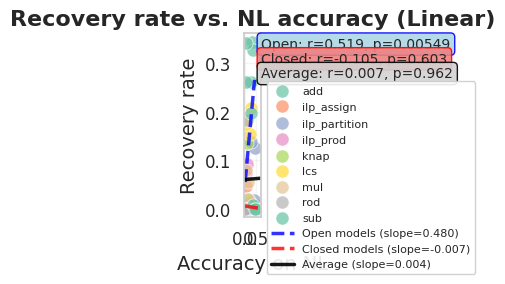

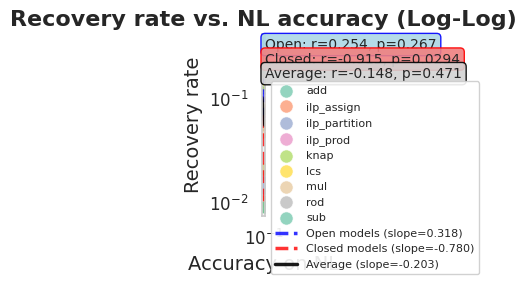

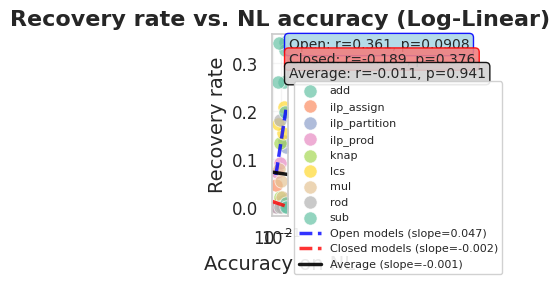

/tmp/ipykernel_48498/1031729253.py:502: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


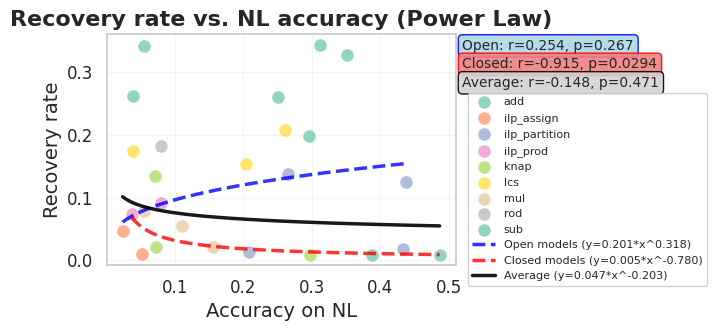

In [211]:
# Generate plots for recovery rate vs nl_accuracy with open/closed model separation
print("=== Recovery Rate vs NL Accuracy (with model type separation) ===")
fig_nl_normal, fig_nl_log, fig_nl_loglin, fig_nl_power = plot_recovery_vs_accuracy_with_model_types(
    accuracy_stats,
    "nl_accuracy",
    "recovery_rate",
    "Recovery rate vs. NL accuracy",
    "Accuracy on NL",
)

In [212]:
# Save the recovery vs nl accuracy plots
figures_dir = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/figures")
figures_dir.mkdir(parents=True, exist_ok=True)

# Save nl accuracy plots
if "fig_nl_normal" in globals() and fig_nl_normal is not None:
    fig_nl_normal.savefig(figures_dir / "recovery_vs_nl_accuracy_linear.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_nl_accuracy_linear.png")
if "fig_nl_log" in globals() and fig_nl_log is not None:
    fig_nl_log.savefig(figures_dir / "recovery_vs_nl_accuracy_loglog.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_nl_accuracy_loglog.png")
if "fig_nl_loglin" in globals() and fig_nl_loglin is not None:
    fig_nl_loglin.savefig(figures_dir / "recovery_vs_nl_accuracy_loglin.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_nl_accuracy_loglin.png")
if "fig_nl_power" in globals() and fig_nl_power is not None:
    fig_nl_power.savefig(figures_dir / "recovery_vs_nl_accuracy_power.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_nl_accuracy_power.png")

Saved: recovery_vs_nl_accuracy_linear.png
Saved: recovery_vs_nl_accuracy_loglog.png
Saved: recovery_vs_nl_accuracy_loglin.png
Saved: recovery_vs_nl_accuracy_power.png


=== Recovery Rate vs Code Exec Accuracy (with model type separation) ===
Open models: 3, Closed models: 3


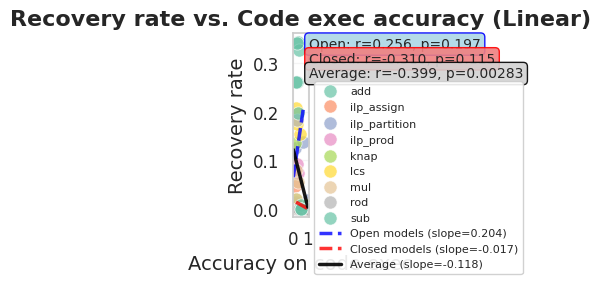

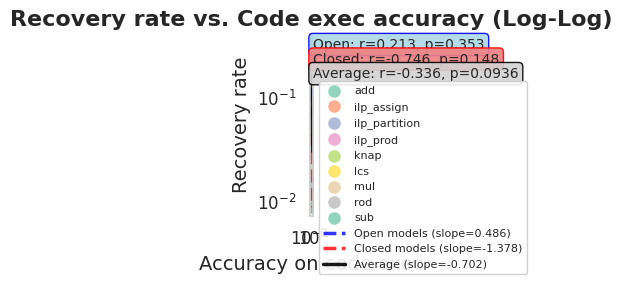

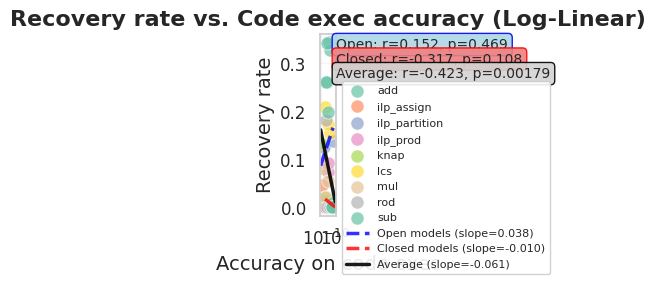

/tmp/ipykernel_48498/1031729253.py:502: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


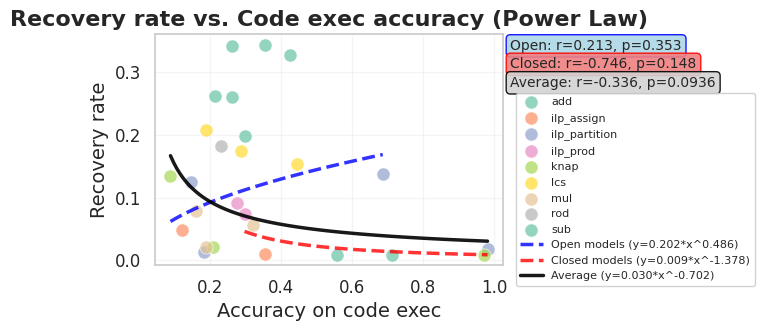

In [213]:
# Generate plots for recovery rate vs code_exec_accuracy with open/closed model separation
print("=== Recovery Rate vs Code Exec Accuracy (with model type separation) ===")
fig_exec_sep_normal, fig_exec_sep_log, fig_exec_sep_loglin, fig_exec_sep_power = plot_recovery_vs_accuracy_with_model_types(
    accuracy_stats,
    "code_exec_accuracy",
    "recovery_rate",
    "Recovery rate vs. Code exec accuracy",
    "Accuracy on code exec",
)

=== Recovery Rate vs Code Sim Accuracy (with model type separation) ===
Open models: 3, Closed models: 3


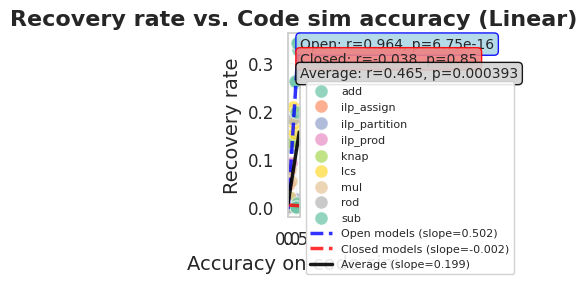

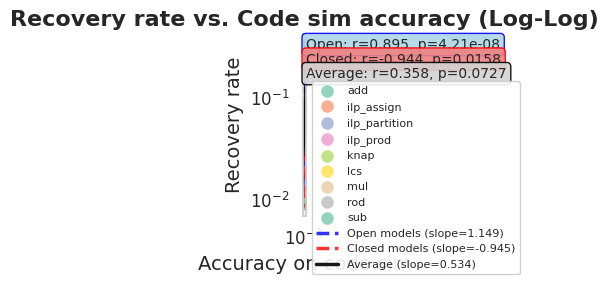

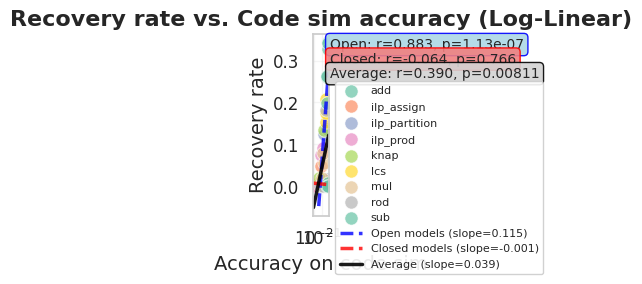

/tmp/ipykernel_48498/1031729253.py:502: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


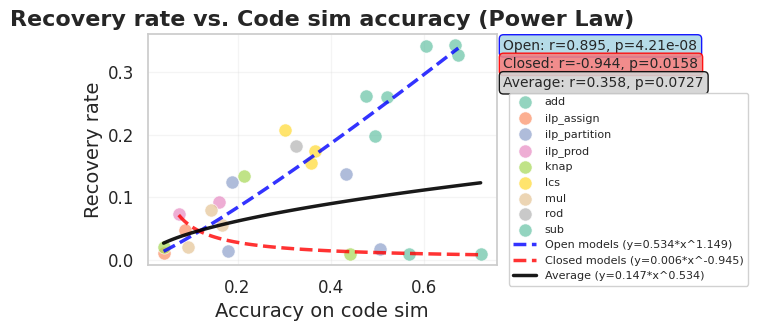

In [214]:
# Generate plots for recovery rate vs code_sim_accuracy with open/closed model separation
print("=== Recovery Rate vs Code Sim Accuracy (with model type separation) ===")
fig_sim_sep_normal, fig_sim_sep_log, fig_sim_sep_loglin, fig_sim_sep_power = plot_recovery_vs_accuracy_with_model_types(
    accuracy_stats,
    "code_sim_accuracy",
    "recovery_rate",
    "Recovery rate vs. Code sim accuracy",
    "Accuracy on code sim",
)

=== Recovery Rate vs Averaged Accuracy (with model type separation) ===
Open models: 3, Closed models: 3


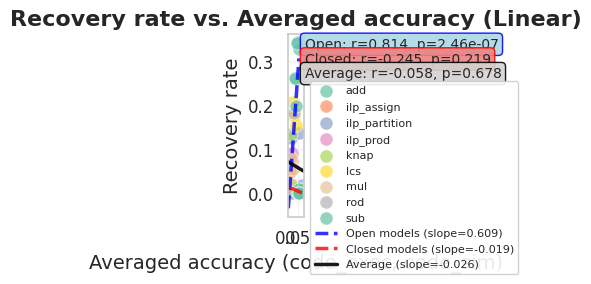

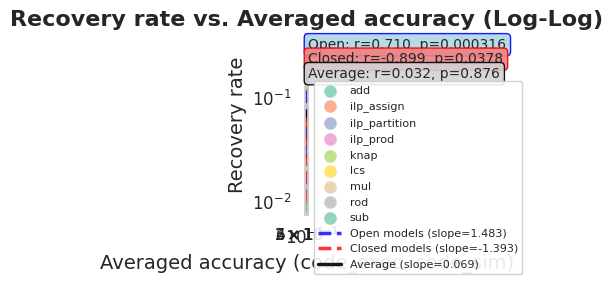

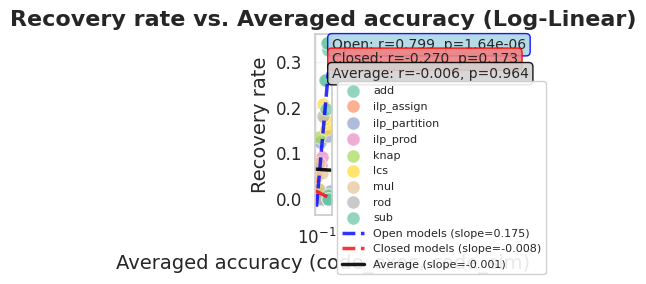

/tmp/ipykernel_48498/1031729253.py:502: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


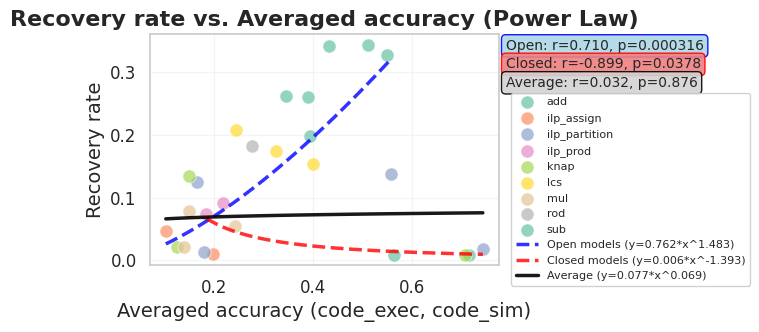

In [215]:
# Generate plots for recovery rate vs averaged_accuracy with open/closed model separation
print("=== Recovery Rate vs Averaged Accuracy (with model type separation) ===")
fig_avg_sep_normal, fig_avg_sep_log, fig_avg_sep_loglin, fig_avg_sep_power = plot_recovery_vs_accuracy_with_model_types(
    accuracy_stats,
    "averaged_accuracy",
    "recovery_rate",
    "Recovery rate vs. Averaged accuracy",
    "Averaged accuracy (code_exec, code_sim)",
)

In [216]:
# Save all the plots with model separation
figures_dir = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/figures")
figures_dir.mkdir(parents=True, exist_ok=True)

# Save code exec plots with separation
if "fig_exec_sep_normal" in globals() and fig_exec_sep_normal is not None:
    fig_exec_sep_normal.savefig(figures_dir / "recovery_vs_code_exec_linear_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_exec_linear_sep.png")
if "fig_exec_sep_log" in globals() and fig_exec_sep_log is not None:
    fig_exec_sep_log.savefig(figures_dir / "recovery_vs_code_exec_loglog_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_exec_loglog_sep.png")
if "fig_exec_sep_loglin" in globals() and fig_exec_sep_loglin is not None:
    fig_exec_sep_loglin.savefig(figures_dir / "recovery_vs_code_exec_loglin_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_exec_loglin_sep.png")
if "fig_exec_sep_power" in globals() and fig_exec_sep_power is not None:
    fig_exec_sep_power.savefig(figures_dir / "recovery_vs_code_exec_power_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_exec_power_sep.png")

# Save code sim plots with separation
if "fig_sim_sep_normal" in globals() and fig_sim_sep_normal is not None:
    fig_sim_sep_normal.savefig(figures_dir / "recovery_vs_code_sim_linear_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_sim_linear_sep.png")
if "fig_sim_sep_log" in globals() and fig_sim_sep_log is not None:
    fig_sim_sep_log.savefig(figures_dir / "recovery_vs_code_sim_loglog_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_sim_loglog_sep.png")
if "fig_sim_sep_loglin" in globals() and fig_sim_sep_loglin is not None:
    fig_sim_sep_loglin.savefig(figures_dir / "recovery_vs_code_sim_loglin_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_sim_loglin_sep.png")
if "fig_sim_sep_power" in globals() and fig_sim_sep_power is not None:
    fig_sim_sep_power.savefig(figures_dir / "recovery_vs_code_sim_power_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_code_sim_power_sep.png")

# Save averaged accuracy plots with separation
if "fig_avg_sep_normal" in globals() and fig_avg_sep_normal is not None:
    fig_avg_sep_normal.savefig(figures_dir / "recovery_vs_avg_accuracy_linear_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_avg_accuracy_linear_sep.png")
if "fig_avg_sep_log" in globals() and fig_avg_sep_log is not None:
    fig_avg_sep_log.savefig(figures_dir / "recovery_vs_avg_accuracy_loglog_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_avg_accuracy_loglog_sep.png")
if "fig_avg_sep_loglin" in globals() and fig_avg_sep_loglin is not None:
    fig_avg_sep_loglin.savefig(figures_dir / "recovery_vs_avg_accuracy_loglin_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_avg_accuracy_loglin_sep.png")
if "fig_avg_sep_power" in globals() and fig_avg_sep_power is not None:
    fig_avg_sep_power.savefig(figures_dir / "recovery_vs_avg_accuracy_power_sep.png", bbox_inches="tight", dpi=300)
    print(f"Saved: recovery_vs_avg_accuracy_power_sep.png")

Saved: recovery_vs_code_exec_linear_sep.png
Saved: recovery_vs_code_exec_loglog_sep.png
Saved: recovery_vs_code_exec_loglin_sep.png
Saved: recovery_vs_code_exec_power_sep.png
Saved: recovery_vs_code_sim_linear_sep.png
Saved: recovery_vs_code_sim_loglog_sep.png
Saved: recovery_vs_code_sim_loglin_sep.png
Saved: recovery_vs_code_sim_power_sep.png
Saved: recovery_vs_avg_accuracy_linear_sep.png
Saved: recovery_vs_avg_accuracy_loglog_sep.png
Saved: recovery_vs_avg_accuracy_loglin_sep.png
Saved: recovery_vs_avg_accuracy_power_sep.png
